In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.layers import Embedding, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Input, GlobalMaxPooling1D
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split #
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize, OneHotEncoder

## Nacitanie

In [ ]:
dataset = pd.read_csv('../Data/final_dataset_5.csv')

In [ ]:
dataset.shape

(1931, 2)

## Rozdelenie dat na sady

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
print(X_train[:10])

1700    curious know dog really found anything husband...
734     sun fallen almost level cliff slanting upward ...
937     man learn ride fashion day yet year fashions h...
185     bed summer ii thought iii sea-side iv young ni...
699     mack nolan crawled bunk wednesday night though...
1771    sure paddy warned going promised soon pond big...
1350    father saying ah pleasant place wonder lives l...
638     's met misfortune 's use concealing answered d...
21      father fergus tenth direct descent john tower ...
1146    titmarsh boy said one day looking hard face ev...
Name: processed_text, dtype: object


## One hot encoding

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

In [ ]:
print(y_valid)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# TextVectorization

## Model 1

In [ ]:
embedding_dim = 512
vocab_size = 100000
sequence_length = 11000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

In [ ]:
input_layer = Input(shape=(1,), dtype=tf.string)
x_v = vect_layer(input_layer)
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(x_v)
x = tf.keras.layers.Conv1D(512, kernel_size=4, padding="valid", activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 11000)             0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 11000, 512)        51200000  
                                                                 
 conv1d (Conv1D)             (None, 10997, 512)        1049088   
                                                                 
 max_pooling1d (MaxPooling1  (None, 5498, 512)         0         
 D)                                                              
                                                                 
 global_average_pooling1d (  (None, 512)               0     

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=15, batch_size = 32, callbacks=[model_checkpoint_callback])

Epoch 1/15
40/40 [==============================] - 34s 538ms/step - loss: 4.1737 - accuracy: 0.0718 - val_loss: 3.7462 - val_accuracy: 0.1277
Epoch 2/15
40/40 [==============================] - 12s 311ms/step - loss: 3.7966 - accuracy: 0.1294 - val_loss: 3.3845 - val_accuracy: 0.2695
Epoch 3/15
40/40 [==============================] - 12s 308ms/step - loss: 3.3568 - accuracy: 0.2202 - val_loss: 2.9441 - val_accuracy: 0.3262
Epoch 4/15
40/40 [==============================] - 13s 324ms/step - loss: 2.9377 - accuracy: 0.2857 - val_loss: 2.5549 - val_accuracy: 0.4113
Epoch 5/15
40/40 [==============================] - 13s 324ms/step - loss: 2.4970 - accuracy: 0.3828 - val_loss: 2.2023 - val_accuracy: 0.4539
Epoch 6/15
40/40 [==============================] - 12s 306ms/step - loss: 2.0568 - accuracy: 0.4775 - val_loss: 1.9000 - val_accuracy: 0.5390
Epoch 7/15
40/40 [==============================] - 12s 306ms/step - loss: 1.6816 - accuracy: 0.5699 - val_loss: 1.7110 - val_accuracy: 0.6241

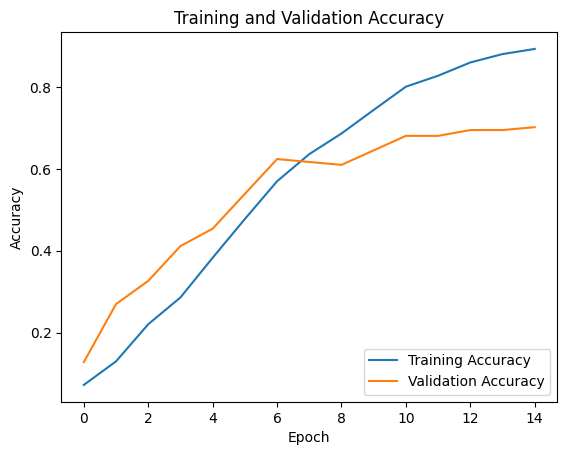

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

11/11 [==============================] - 1s 101ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.7017045454545454
F1 Score: 0.6961300885680372
Precision: 0.741039719640263
Recall: 0.7017045454545454


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
